In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from tifffile import imread

In [168]:
# define paths
data_path = "../../../Output/Measurements/"
output_path = "../../../Output/Figures/"
img_path = "../../../Input/Data/multichannel_cell_count/20221121/rename/"

choices_map = {1:'ch2 pos', 2:'ch3 pos', 3:'double pos', 4:'double neg'}

# read in data
df = (pd.read_csv(data_path + 'measurements_classification.csv')
    .assign(condition = lambda df_: df_.condition.astype('category'),
            cat_string = lambda df_: df_.category_otsu.map(choices_map))
)

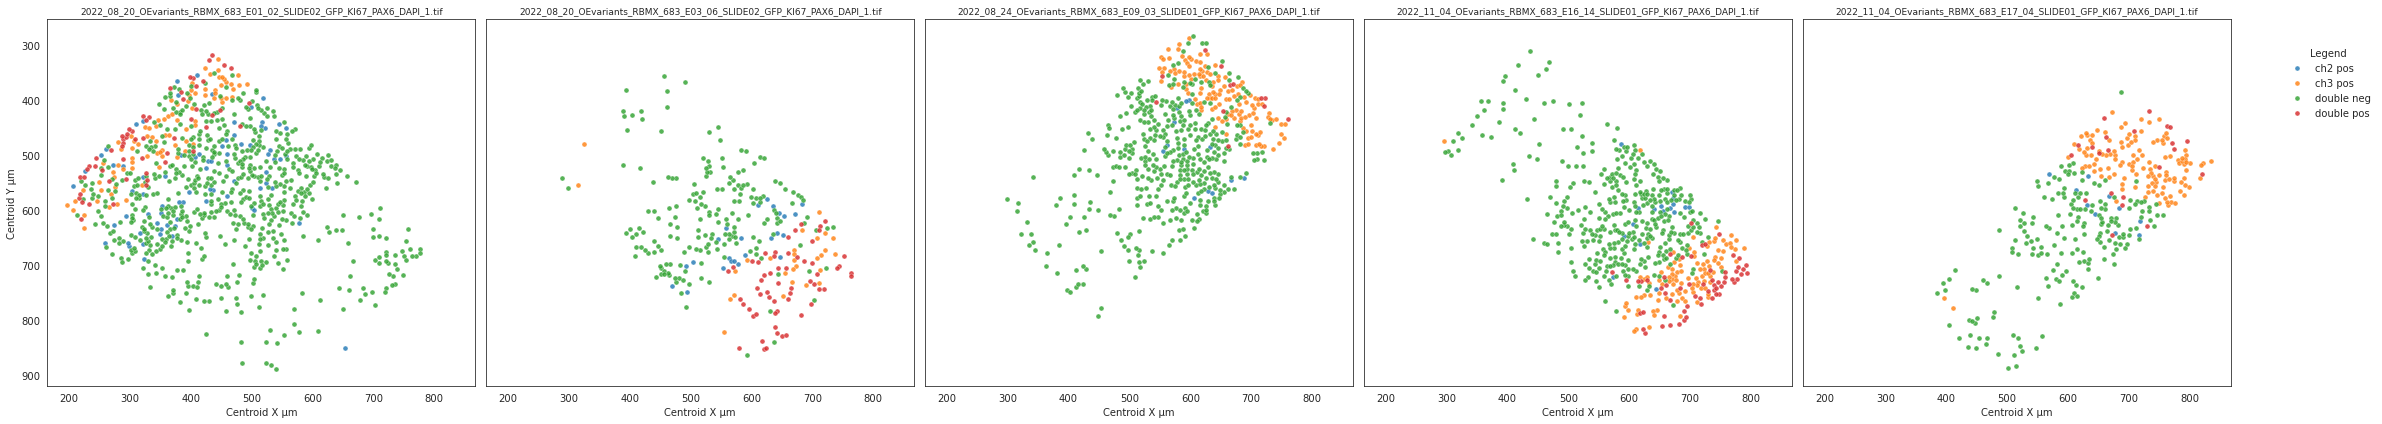

In [109]:
# Selected filenames
filenames = [
    '2022_08_20_OEvariants_RBMX_683_E01_02_SLIDE02_GFP_KI67_PAX6_DAPI_1.tif',
    '2022_08_20_OEvariants_RBMX_683_E03_06_SLIDE02_GFP_KI67_PAX6_DAPI_1.tif',
    '2022_08_24_OEvariants_RBMX_683_E09_03_SLIDE01_GFP_KI67_PAX6_DAPI_1.tif',
    '2022_11_04_OEvariants_RBMX_683_E17_04_SLIDE01_GFP_KI67_PAX6_DAPI_1.tif',
    '2022_11_04_OEvariants_RBMX_683_E16_14_SLIDE01_GFP_KI67_PAX6_DAPI_1.tif'
]

df_maps = df[df.Image.isin(filenames)].copy()

g = sns.FacetGrid(data=df_maps, col='Image', col_wrap=6, 
                hue='cat_string', hue_order=['ch2 pos', 'ch3 pos', 'double neg', 'double pos'],
                sharex=True,
                aspect=1, height=6)

g.map_dataframe(sns.scatterplot, x='Centroid X µm', y='Centroid Y µm', s=25, alpha=0.8)
g.set_titles(col_template='{col_name}', size=9)

for ax in g.axes.ravel():
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.invert_yaxis() # Invert Y axis so it's flipped as the original image

g.add_legend(title='Legend')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.85, 0.9))

plt.tight_layout()

In [167]:
# Comparison of threshold for selected images
choices_map = {1:'ch2 pos', 2:'ch3 pos', 3:'double pos', 4:'double neg'}

for filename in filenames:
    f, axes = plt.subplots(1, 4, figsize=(20,4))
    df_map = df[df.Image == filename].copy()
    for ax, col in zip(axes, df.columns[-5:-1]):
        df_map['cat_string'] = df_map[col].map(choices_map)
        sns.scatterplot(data=df_map, x='Centroid X µm', y='Centroid Y µm', hue='cat_string', alpha=0.6, ax=ax, legend=False, s=10)
        ax.set_title(col)
    f.savefig(output_path + 'pseudomaps/' + filename + '_map_thresh_comp.pdf')
    plt.close()

In [170]:
# Image overlay with cell centroids
for file in filenames:
    f, ax = plt.subplots(1,1, figsize=(10,10))
    img = imread(img_path + file, key=0)
    df_maps = df[df.Image == file].copy()

    ax.imshow(img, vmin=np.percentile(img, 1), vmax=np.percentile(img, 99), cmap='viridis')
    ax.scatter(df_maps['Centroid X µm'] / 0.568, df_maps['Centroid Y µm'] / 0.568, s=2, c='red')
    ax.set_xlim(((df_maps['Centroid X µm'] / 0.568).min(), (df_maps['Centroid X µm'] / 0.568).max()))
    ax.set_ylim(((df_maps['Centroid Y µm'] / 0.568).min(), (df_maps['Centroid Y µm'] / 0.568).max()))
    ax.invert_yaxis()
    ax.axis('off')
    f.savefig(output_path + 'pseudomaps/' +  file + '_overlay.png', dpi=300, bbox_inches='tight')
    plt.close()

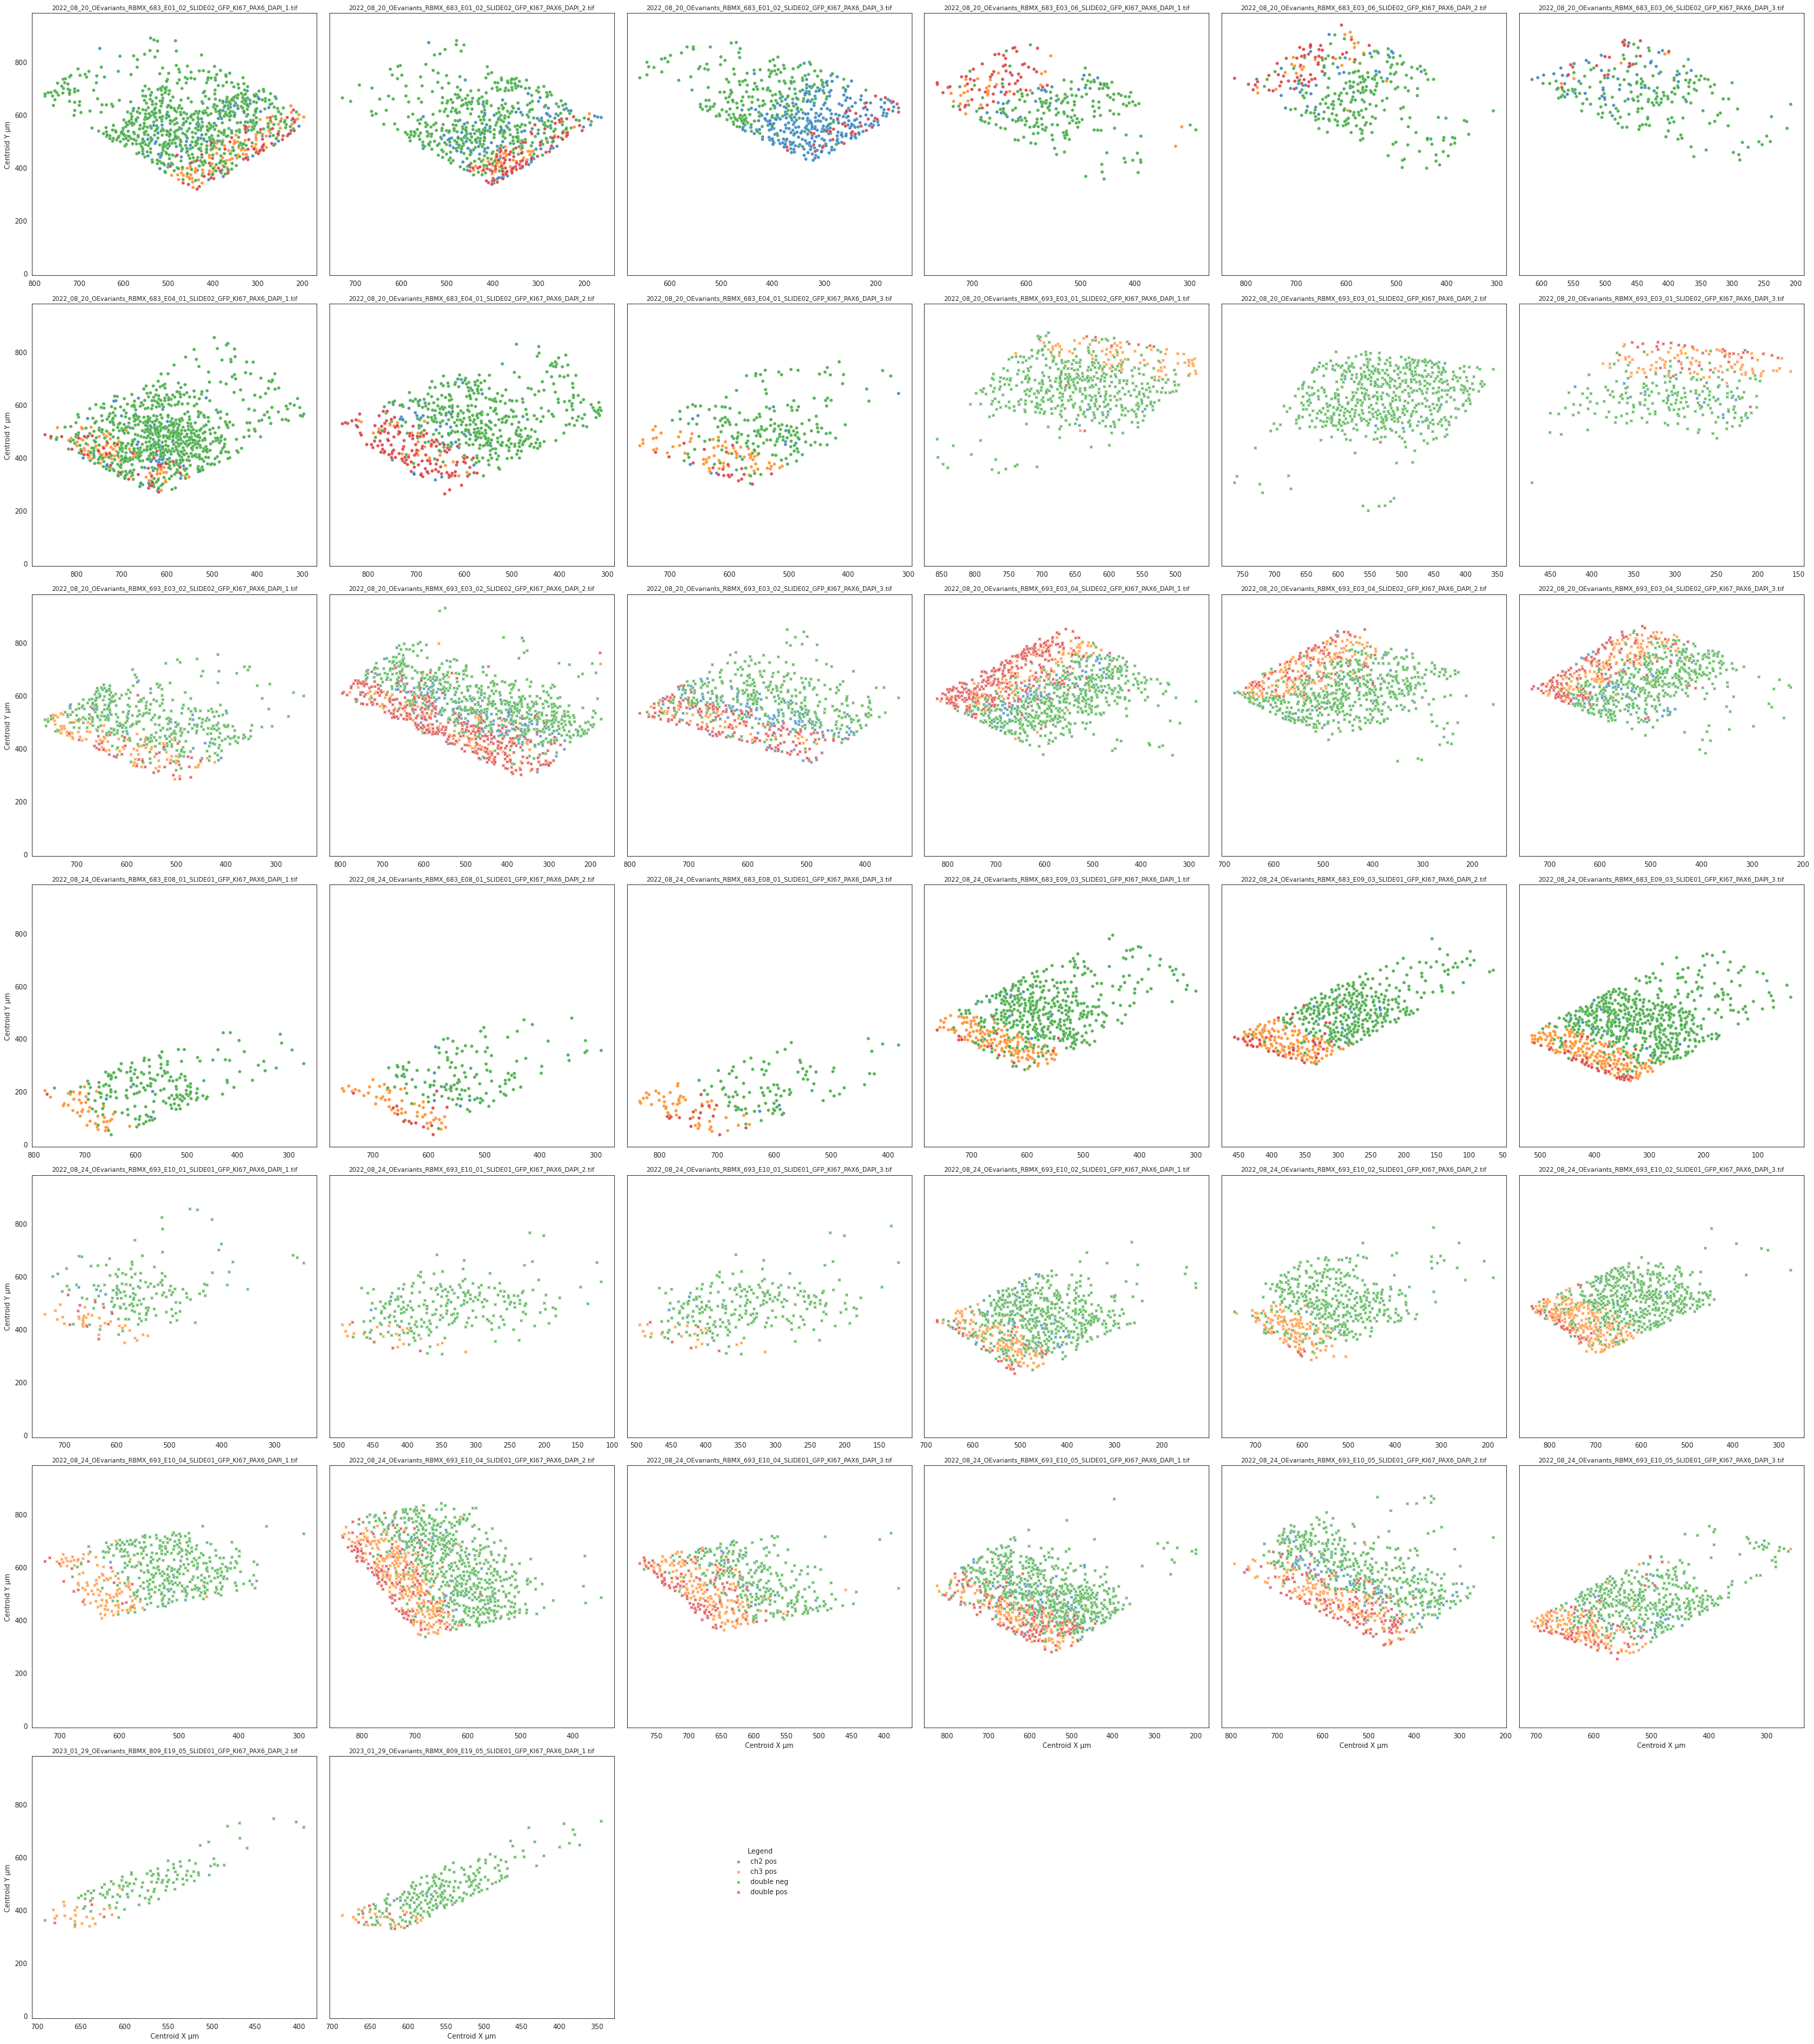

In [90]:
# Create pseudomaps of location of every cell for every image in conditions 2 and 4 using centroid coordinates from QuPath

df_maps = df.query("condition in [2,4]").copy()

sns.set_style('white')

g = sns.FacetGrid(data=df_maps, col='Image', col_wrap=6, 
                hue='cat_string', hue_order=['ch2 pos', 'ch3 pos', 'double neg', 'double pos'],
                sharex=False, # I have to not share it if I want to invert axis
                aspect=1, height=6)

g.map_dataframe(sns.scatterplot, x='Centroid X µm', y='Centroid Y µm', style='condition', markers=['o','X'], style_order=[2,4], s=25, alpha=0.8)
g.set_titles(col_template='{col_name}', size=9)

for ax in g.axes.ravel():
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.invert_xaxis() # Invert X axis so it's flipped as the original image

g.add_legend(title='Legend')
sns.move_legend(g, "upper left", bbox_to_anchor=(.4, .1))

plt.tight_layout()
plt.savefig(output_path + "pseudomap_conditions_2-4.pdf")
plt.show()